In [1]:
import pulse2percept as p2p
import numpy as np
import matplotlib.pyplot as plt
import torch
import math
import cv2
import utils

import sys
sys.path.append('../ZoeDepth')
from zoedepth.utils.misc import get_image_from_url, colorize
from PIL import Image

%matplotlib inline

In [2]:
zoe = torch.hub.load("../ZoeDepth", "ZoeD_N", source="local", pretrained=True)

img_size [384, 512]


Using cache found in /home/csirlin/.cache/torch/hub/intel-isl_MiDaS_master


Params passed to Resize transform:
	width:  512
	height:  384
	resize_target:  True
	keep_aspect_ratio:  True
	ensure_multiple_of:  32
	resize_method:  minimal
Using pretrained resource url::https://github.com/isl-org/ZoeDepth/releases/download/v1.0/ZoeD_M12_N.pt
Loaded successfully


In [3]:
# img_url = "http://static1.squarespace.com/static/6213c340453c3f502425776e/62f2452bc121595f4d87c713/62f3c63c5eec2b12a333f851/1661442296756/Screenshot+2022-08-10+at+15.55.27.png?format=1500w" #@param {type:"string"}
# img = get_image_from_url(img_url)
image_path = "depth.jpg"  # Change to your image path
img = Image.open(image_path)
depth = zoe.infer_pil(img)
img = np.array(img)

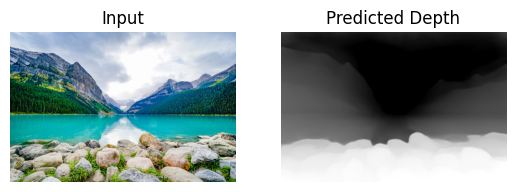

In [4]:
colored_depth = colorize(depth)
fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, colored_depth], ['Input', 'Predicted Depth']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

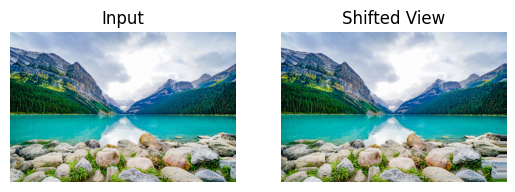

In [5]:
# compute shifted image
warped_image = utils.compute_right_eye(img, depth, 60, shift=0.063)

fig, axs = plt.subplots(1,2)
for ax, im, title in zip(axs, [img, warped_image], ['Input', 'Shifted View']):
  ax.imshow(im)
  ax.axis('off')
  ax.set_title(title)

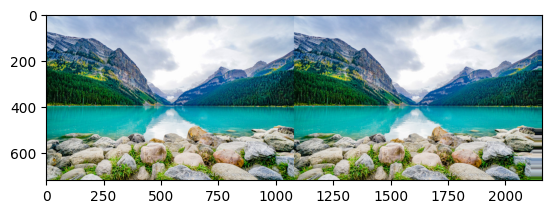

In [6]:
# look closely to get the magic eye/3D effect
img_and_warped = np.hstack((img, warped_image))
plt.imshow(img_and_warped)
# im = Image.fromarray(img_and_warped)
# im.save("../output.jpeg")

In [7]:
### pulse2percept time ###
scoreboard = p2p.models.ScoreboardModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=100)
scoreboard.build()

axon_left = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, eye="LE")
axon_left.build()

axon_right = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, eye="RE")
axon_right.build()

AxonMapModel(ax_segments_range=(0, 50), axlambda=500, 
             axon_pickle='axons.pickle', 
             axons_range=(-180, 180), engine=None, 
             eye='RE', grid_type='rectangular', 
             ignore_pickle=False, loc_od=(15.5, 1.5), 
             min_ax_sensitivity=0.001, n_ax_segments=500, 
             n_axons=1000, n_gray=None, n_jobs=1, 
             n_threads=4, ndim=[2], noise=None, rho=200, 
             scheduler='threading', spatial=AxonMapSpatial, 
             temporal=None, thresh_percept=0, verbose=True, 
             vfmap=Watson2014Map(ndim=2), xrange=(-12, 12), 
             xystep=0.1, yrange=(-12, 12))

In [8]:
def get_side_by_side(left_pros, right_pros, left_img, right_img, left_model, right_model):
    percept_left = utils.get_percept_data_from_image(left_img, left_model, left_pros)
    percept_right = utils.get_percept_data_from_image(right_img, right_model, right_pros)
    return np.hstack((percept_left, percept_right))

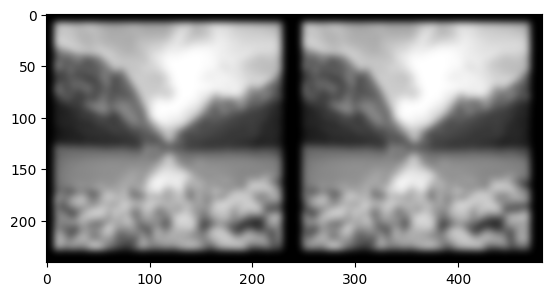

In [ ]:
# Direct image stimulus, big prosthetic, scoreboard
# big effect!
big_prosthetic_left = utils.get_big_prosthesis("LE")
big_prosthetic_right = utils.get_big_prosthesis("RE")
plt.imshow(get_side_by_side(big_prosthetic_left, big_prosthetic_right, img, warped_image, 
                            scoreboard, scoreboard), cmap='gray')

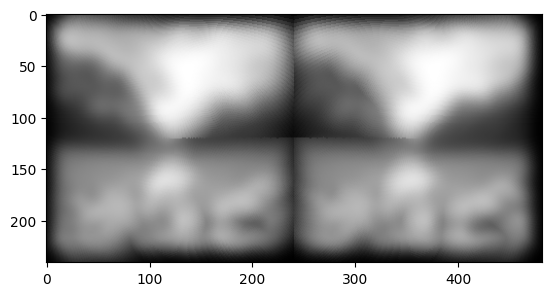

In [ ]:
# Direct image stimulus, big prosthetic, axon map model
# still works a little (and takes ~60x longer :P)
plt.imshow(get_side_by_side(big_prosthetic_left, big_prosthetic_right, img, warped_image, 
                            axon_left, axon_right), cmap='gray')

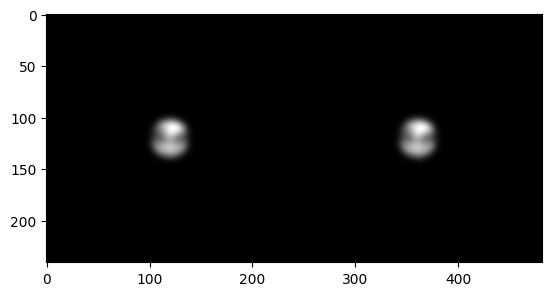

In [ ]:
# Direct image stimulus, PRIMA 40, scoreboard
# image is too small to see the effect - prima's FOV is too narrow
prima_40_left = p2p.implants.PRIMA40(eye="LE")
prima_40_right = p2p.implants.PRIMA40(eye="RE")
plt.imshow(get_side_by_side(prima_40_left, prima_40_right, img, warped_image, 
                            scoreboard, scoreboard), cmap='gray')

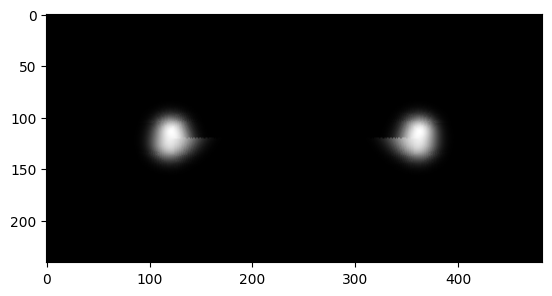

In [ ]:
# Direct image stimulus, PRIMA 40, axon map model
# small image and totally washed out
plt.imshow(get_side_by_side(prima_40_left, prima_40_right, img, warped_image, 
                            axon_left, axon_right), cmap='gray')

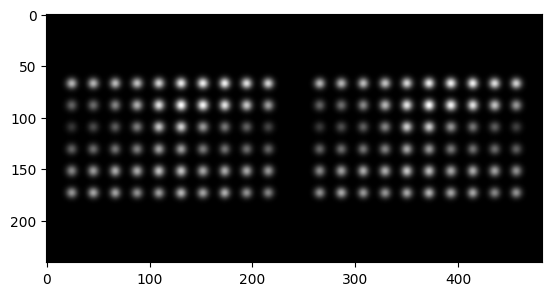

In [ ]:
# Direct image stimulus, Argus II, scoreboard
# not enough resolution to see details or 3D effect
# but the image is spread out - you can tell what you're looking at if you've seen the original image
argus_left = p2p.implants.ArgusII(eye="LE")
argus_right = p2p.implants.ArgusII(eye="RE")
plt.imshow(get_side_by_side(argus_left, argus_right, img, warped_image, 
                            scoreboard, scoreboard), cmap='gray')

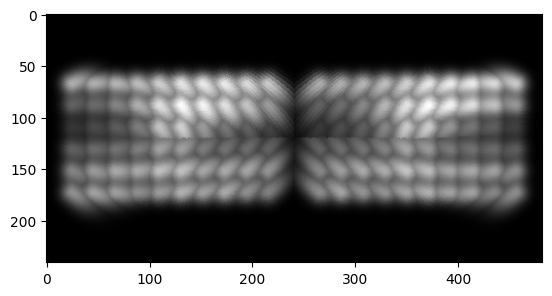

In [ ]:
# Direct image stimulus, Argus II, scoreboard
# again, you can tell what you're looking at if you've seen the original (if anything it's easier), 
# but there's not enough resolution to make out the details or to have a 3D effect
plt.imshow(get_side_by_side(argus_left, argus_right, img, warped_image, 
                            axon_left, axon_right), cmap='gray')

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

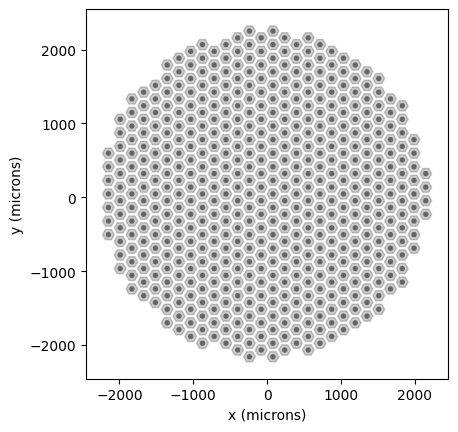

In [15]:
# since argus II is spread out but has limited resolution, and PRIMA 40 is high resolution
# but has such a narrow FOV, what if we have the best of both worlds?

# let's expand PRIMA 40 to have the same FOV as Argus II. Argus II is a rectangle that 
# ranges from +/- 2587.5 on the x-axis and +/- 1437.5 on the y-axis. (roughly 5200*2900 
# for an area of 14,872,950 um^2). meanwhile PRIMA is a circle roughly 425 um in diameter
# (704,352 um^2). So PRIMA40 should have 21x the volume it currently does to match. Argus II's.
# This means each electrode should be 4.6x bigger in each direction.

# this is somewhat realistic, since this device is being prototyped and honestly having the 
# same number of electrodes but making them larger and wider spread is probably easier than 
# making the actual PRIMA 40

scale_factor = 4.595
big_prima_array = p2p.implants.ElectrodeArray([])
e_count = 0
for electrode_object in prima_40_left.electrode_objects:
    big_prima_array.add_electrode(e_count, 
                                  p2p.implants.PhotovoltaicPixel(scale_factor * electrode_object.x, 
                                                                 scale_factor * electrode_object.y, 
                                                                 z = -100, r = scale_factor * 8,
                                                                 a = 35/2*scale_factor))
    e_count += 1

big_prima_left = p2p.implants.ProsthesisSystem(big_prima_array, eye="LE")
big_prima_right = p2p.implants.ProsthesisSystem(big_prima_array, eye="RE")
big_prima_left.plot()

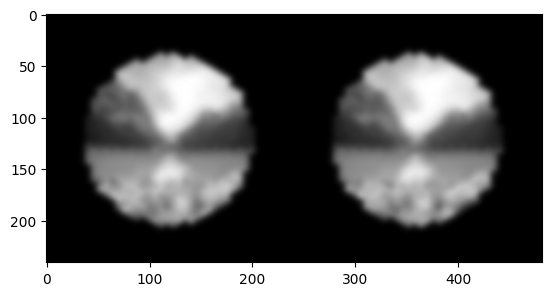

In [ ]:
# Direct image stimulus, big PRIMA 40, scoreboard
# I can see the 3D effect a little
plt.imshow(get_side_by_side(big_prima_left, big_prima_right, img, warped_image, 
                            scoreboard, scoreboard), cmap='gray')

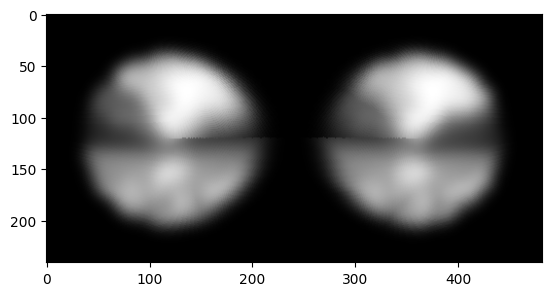

In [ ]:
# Direct image stimulus, big PRIMA 40, axon map model
# no more 3D, but at least I can actually see the image
plt.imshow(get_side_by_side(big_prima_left, big_prima_right, img, warped_image, 
                            axon_left, axon_right), cmap='gray')

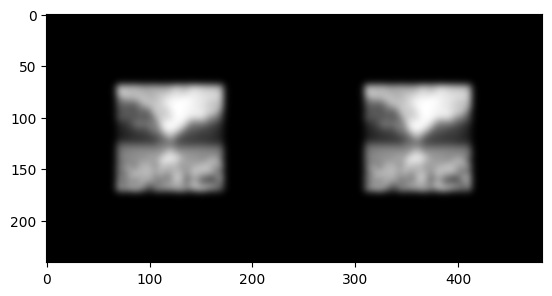

In [ ]:
# Direct image stimulus, Alpha AMS, scoreboard
# honestly not far off from the idealized big_prosthetic
alpha_ams_left = p2p.implants.AlphaAMS(eye="LE")
alpha_ams_right = p2p.implants.AlphaAMS(eye="RE")
plt.imshow(get_side_by_side(alpha_ams_left, alpha_ams_right, img, warped_image, 
                            scoreboard, scoreboard), cmap='gray')


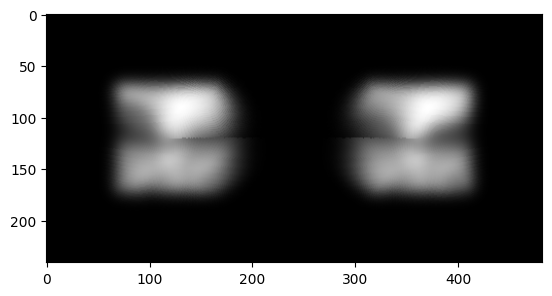

In [ ]:
# Direct image stimulus, Alpha AMS, scoreboard
# not great
plt.imshow(get_side_by_side(alpha_ams_left, alpha_ams_right, img, warped_image, 
                            axon_left, axon_right), cmap='gray')

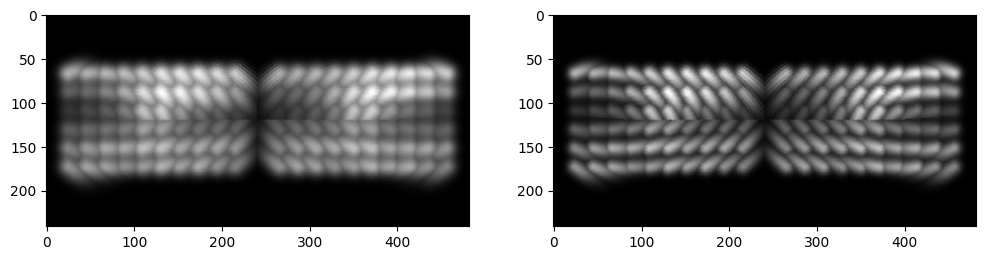

In [20]:
# testing axon map model parameters in argus
argus_percept_left = utils.get_percept_data_from_image(img, axon_left, argus_left)
argus_percept_right = utils.get_percept_data_from_image(img, axon_right, argus_right)

axon_left_diff = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=150, axlambda=500, eye="LE")
axon_left_diff.build()

axon_right_diff = p2p.models.AxonMapModel(xrange=(-12, 12), yrange=(-12, 12), xystep=0.1, rho=150, axlambda=500, eye="RE")
axon_right_diff.build()

argus_percept_left_diff = utils.get_percept_data_from_image(img, axon_left_diff, argus_left)
argus_percept_right_diff = utils.get_percept_data_from_image(img, axon_right_diff, argus_right)

# resulting view is basically useless
percept_side_by_side = np.hstack((argus_percept_left, argus_percept_right))
percept_side_by_side_diff = np.hstack((argus_percept_left_diff, argus_percept_right_diff))
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(percept_side_by_side, cmap='gray')
axes[1].imshow(percept_side_by_side_diff, cmap='gray')
plt.show()

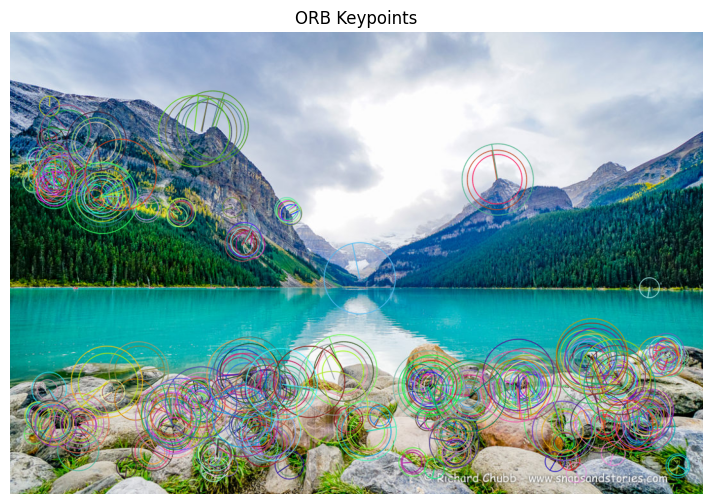

In [21]:
# Let's try pre-processing the image with keypoints instead... maybe it will be
# a less cluttered image and depth perception can remain. 

# the big idea is that a dense electrode grid with the axon map model gets washed
# out, because there's just too much noise - nearby pixels in the image overlap too
# heavily. what if instead, we show a sparser selection of points? that way even if
# the phosphenes are large, they won't overlap as much. With a dense electrode grid,
# it might still be possible to get a highly accurate position for each key point
# even if the points are quite big. And an accurate position in each image is what
# will give the 3D effect!

# detect keypoints with ORB
kp_left, kp_right, img_keypoints = utils.get_keypoint_positions(img, depth, \
                                                 num_to_include=100, fov=60, \
                                                 shift=0.063)

# Display the image with keypoints
plt.figure(figsize=(10, 6))
plt.imshow(img_keypoints, cmap='gray')
plt.title("ORB Keypoints")
plt.axis("off")
plt.show()

(720, 1080, 3)


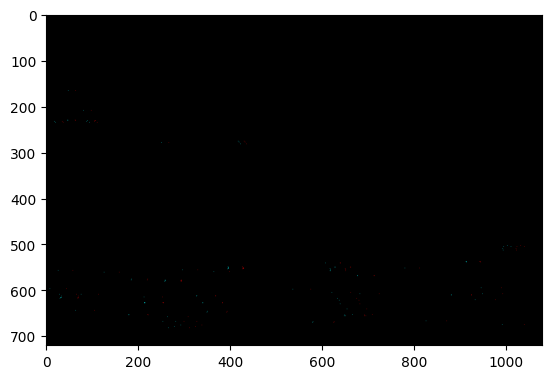

In [22]:
# showing how the keypoints are distributed differently in the two images
empty = np.zeros(img.shape)
print(img.shape)
for (j, i) in kp_left:
    empty[int(i)][int(j)] = [1, 0, 0]
for (j, i) in kp_right:
    empty[int(i)][int(j)] = [0, 1, 1]
plt.imshow(empty)

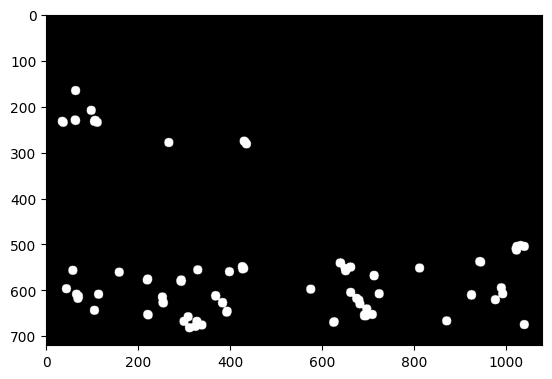

In [23]:
# stimulus from left keypoints
kp_left_img = utils.get_keypoint_image(img.shape, kp_left)
plt.imshow(kp_left_img)

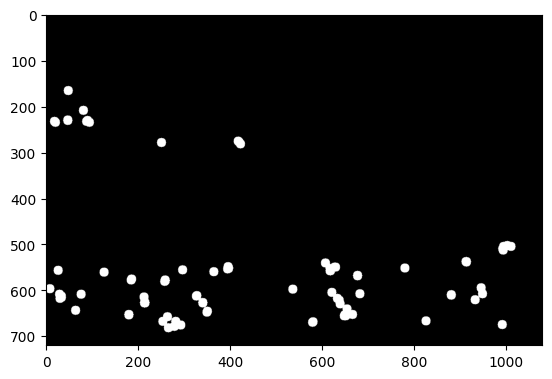

In [24]:
# stimulus from right keypoints
kp_right_img = utils.get_keypoint_image(img.shape, kp_right)
plt.imshow(kp_right_img)

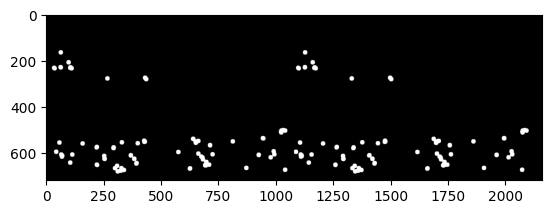

In [25]:
# side by side stimuli
percept_side_by_side = np.hstack((kp_left_img, kp_right_img))
plt.imshow(percept_side_by_side, cmap='gray')

In [26]:
# now we map these key points onto electodes

# dumb way: use the keypoint images themselves as stimuli
# smart way: use the keypoints to trigger the closest electrode to each keypoint
# try both of these with big_prosthetic and argusII. 

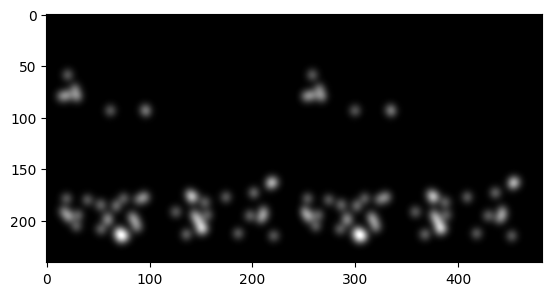

In [ ]:
# Keypoint image stimulus, big prosthetic, scoreboard
# i think this works pretty well actually
plt.imshow(get_side_by_side(big_prosthetic_left, big_prosthetic_right, kp_left_img, kp_right_img, 
                            scoreboard, scoreboard), cmap='gray')

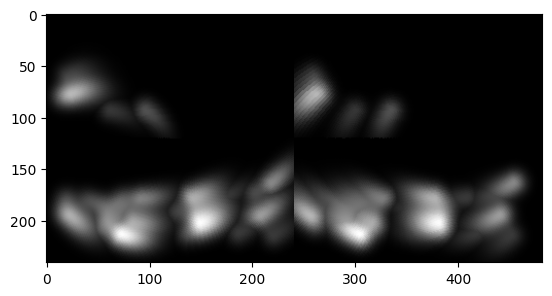

In [ ]:
# Keypoint image stimulus, big prosthetic, axon map model
# doesn't really work because the tails are just so big!
plt.imshow(get_side_by_side(big_prosthetic_left, big_prosthetic_right, kp_left_img, kp_right_img, 
                            axon_left, axon_right), cmap='gray')

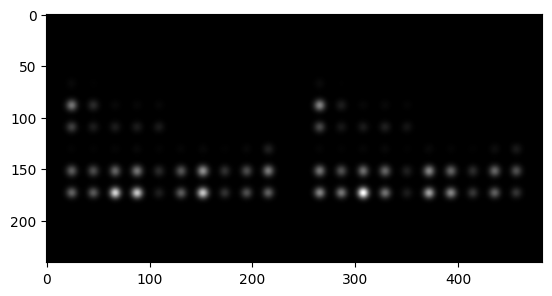

In [ ]:
# Keypoint image stimulus, Argus II, scoreboard
# not enough data for a good representation. a lot like using the original image
# as a stimulus, but worse because it excludes regions that don't have keypoints
plt.imshow(get_side_by_side(argus_left, argus_right, kp_left_img, kp_right_img, 
                            scoreboard, scoreboard), cmap='gray')

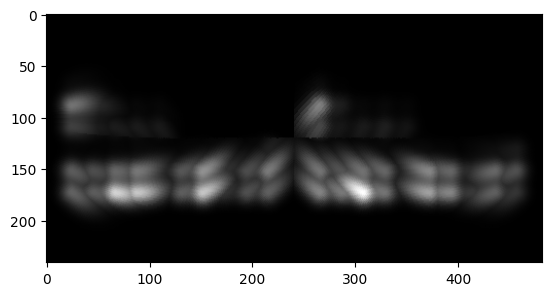

In [ ]:
# Keypoint image stimulus, Argus II, axon map model
# useless
plt.imshow(get_side_by_side(argus_left, argus_right, kp_left_img, kp_right_img, 
                            axon_left, axon_right), cmap='gray')

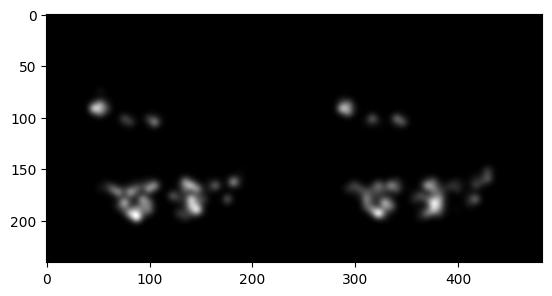

In [ ]:
# Keypoint image stimulus, big PRIMA 40, scoreboard
# not bad
plt.imshow(get_side_by_side(big_prima_left, big_prima_right, kp_left_img, kp_right_img, 
                            scoreboard, scoreboard), cmap='gray')

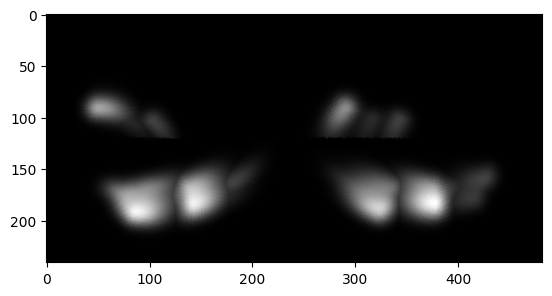

In [ ]:
# Keypoint image stimulus, big PRIMA 40, axon map model
# terrible!
plt.imshow(get_side_by_side(big_prima_left, big_prima_right, kp_left_img, kp_right_img, 
                            axon_left, axon_right), cmap='gray')

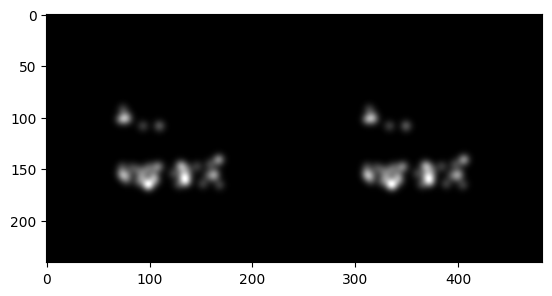

In [ ]:
# Keypoint image stimulus, Alpha AMS, scoreboard
# decent
plt.imshow(get_side_by_side(alpha_ams_left, alpha_ams_right, kp_left_img, kp_right_img, 
                            scoreboard, scoreboard), cmap='gray')

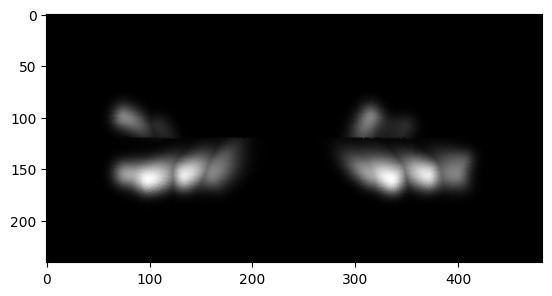

In [44]:
# Keypoint image stimulus, Alpha AMS, axon map model
# marginal/no effect
plt.imshow(get_side_by_side(alpha_ams_left, alpha_ams_right, kp_left_img, kp_right_img, 
                            axon_left, axon_right), cmap='gray')

In [ ]:
### stimulate nearest electrode to each keypoint ###

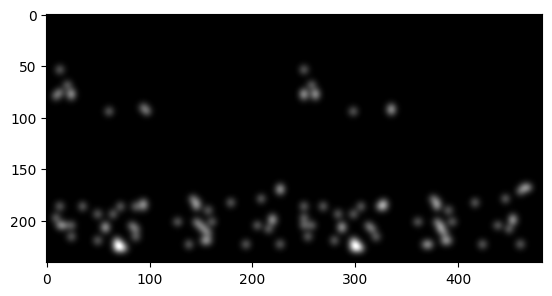

In [ ]:
# Nearest electrode stimulus, big prosthetic, scoreboard
# pretty similar to the keypoint image stim with big_prosthetic and scoreboard
plt.imshow(get_side_by_side(big_prosthetic_left, big_prosthetic_right, 
                            utils.get_stim_from_key_points(big_prosthetic_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(big_prosthetic_right, kp_right, img.shape[0:2]),
                            scoreboard, scoreboard), cmap='gray')

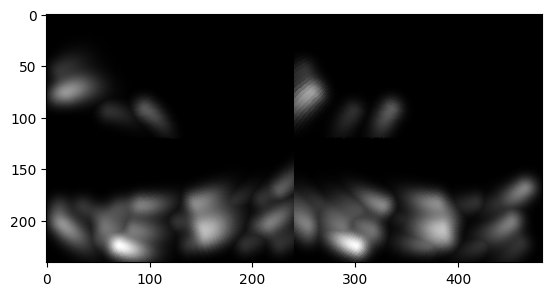

In [ ]:
# Nearest electrode stimulus, big_prosthetic, axon map model
# marginally better than the keypoint image stim with big_prosthetic and axon map model
# there's a little more definition in the percepts with this technique
plt.imshow(get_side_by_side(big_prosthetic_left, big_prosthetic_right, 
                            utils.get_stim_from_key_points(big_prosthetic_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(big_prosthetic_right, kp_right, img.shape[0:2]),
                            axon_left, axon_right), cmap='gray')

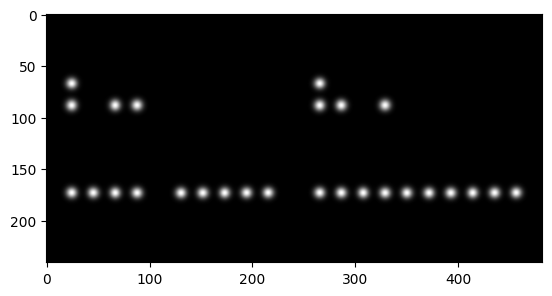

In [ ]:
# Nearest electrode stimulus, Argus II, scoreboard
# useless, keypoint image stimulus is much better here
plt.imshow(get_side_by_side(argus_left, argus_right,
                            utils.get_stim_from_key_points(argus_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(argus_right, kp_right, img.shape[0:2]),
                            scoreboard, scoreboard), cmap='gray')

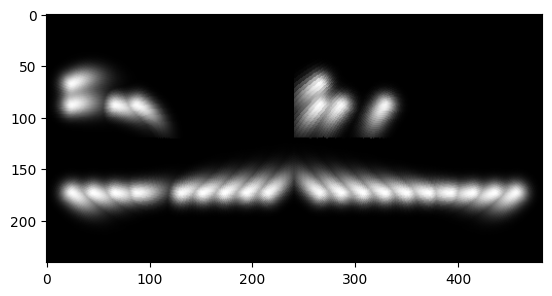

In [ ]:
# Nearest electrode stimulus, Argus II, axon map model
# useless
plt.imshow(get_side_by_side(argus_left, argus_right,
                            utils.get_stim_from_key_points(argus_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(argus_right, kp_right, img.shape[0:2]),
                            axon_left, axon_right), cmap='gray')

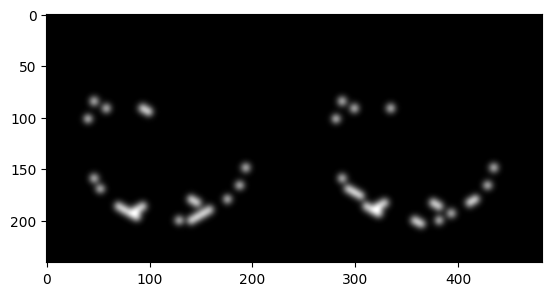

In [ ]:
# Nearest electrode stimulus, big PRIMA 40, scoreboard
# marginal/no effect
plt.imshow(get_side_by_side(big_prima_left, big_prima_right,
                            utils.get_stim_from_key_points(big_prima_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(big_prima_right, kp_right, img.shape[0:2]),
                            scoreboard, scoreboard), cmap='gray')

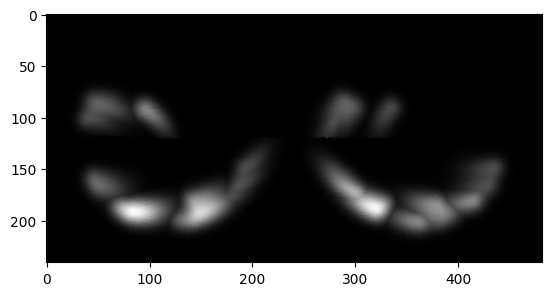

In [ ]:
# Nearest electrode stimulus, big PRIMA 40, axon map model
# marginal/no effect?
plt.imshow(get_side_by_side(big_prima_left, big_prima_right,
                            utils.get_stim_from_key_points(big_prima_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(big_prima_right, kp_right, img.shape[0:2]),
                            axon_left, axon_right), cmap='gray')

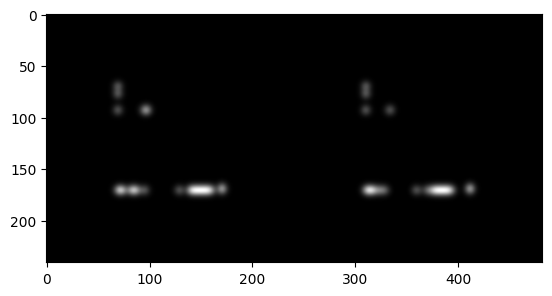

In [ ]:
# Nearest electrode stimulus, Alpha AMS, scoreboard
# marginal/no effect
plt.imshow(get_side_by_side(alpha_ams_left, alpha_ams_right,
                            utils.get_stim_from_key_points(alpha_ams_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(alpha_ams_right, kp_right, img.shape[0:2]),
                            scoreboard, scoreboard), cmap='gray')

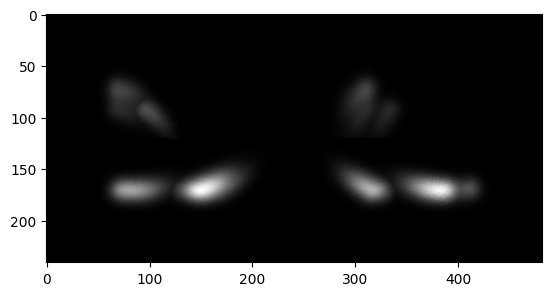

In [ ]:
# Nearest electrode stimulus, Alpha AMS, axon map model
# no effect
plt.imshow(get_side_by_side(alpha_ams_left, alpha_ams_right,
                            utils.get_stim_from_key_points(alpha_ams_left, kp_left, img.shape[0:2]), 
                            utils.get_stim_from_key_points(alpha_ams_right, kp_right, img.shape[0:2]),
                            axon_left, axon_right), cmap='gray')

<Axes: xlabel='x (microns)', ylabel='y (microns)'>

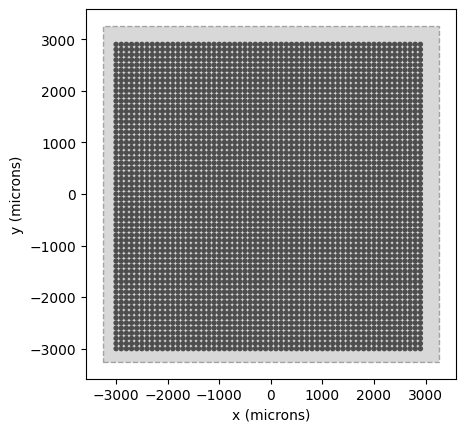

In [36]:
scoreboard.plot()
big_prosthetic_right.plot()